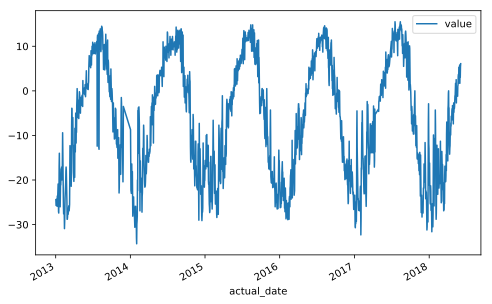

In [166]:
import numpy as np
import pandas as pd
import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 8,5


pd.set_option('precision', 10)

import numpy as np
import pandas as pd
import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 8,5

import mix as mix


pd.set_option('precision', 10)
target_minT = pd.read_csv('./date/31088_103.csv')
X_train = pd.read_csv('./date/character_31088.csv')
X_train = X_train.drop(['point_id'],axis=1)

mix.convert_date(X_train, 'actual_date')
mix.convert_date(target_minT, 'actual_date')

target_minT.set_index('actual_date', inplace=True)
target_minT.sort_values('actual_date', ascending=True).plot()

In [173]:
extracted_month = 5
extracted_year = 2015
extracted_day = 4
predict_date = pd.Timestamp(extracted_year, extracted_month, extracted_day)
#extracted_date = '5/4/2014'

day_delta = 2

extracted_offset = 21
##9, 21. 33, 45, 57, 69
extracted_predict_ = ['min td850']

def md(date):
    return date.strftime('%m-%d')

def month(df, month):
    return df[df.index.month == month]

def year(df, year):
    return df[df.index.year == year]

# +- n day with any year
def offest_n(df, date_point, day_delta):
    offset_day = pd.to_timedelta(day_delta, unit='day')
    start_date = md(date_point - offset_day)
    end_date = md(date_point + offset_day)
    return df[(md(df.index) >= start_date)&(md(df.index) <= end_date)]


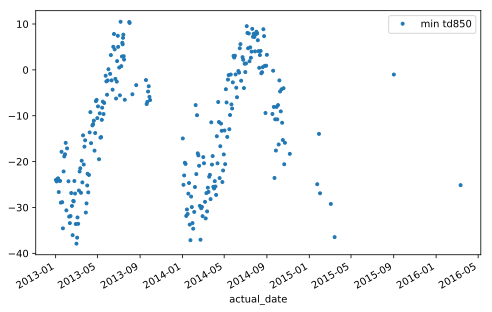

In [174]:
extracted_predict = ['actual_date'] + extracted_predict_


X_train_offset = X_train[X_train['offset_h'] == extracted_offset][extracted_predict]
X_train_offset.set_index('actual_date', inplace=True)
# X_train_offset['actual_date'] = X_train_offset.index.to_period('D')
# X_train_offset.set_index('actual_date', inplace=True)
X_train_offset.plot(style='.')


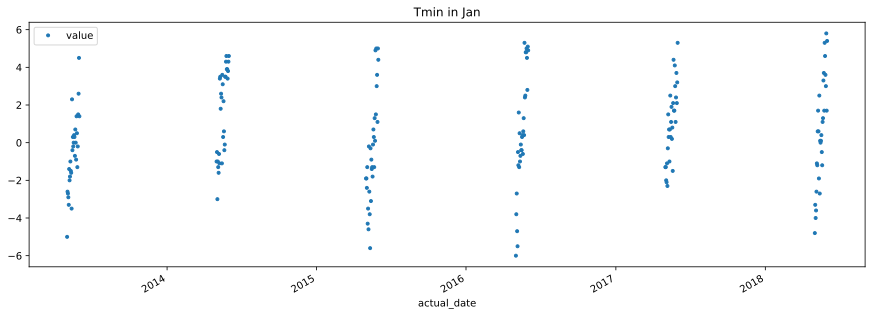

In [175]:
test = month(target_minT,extracted_month)

_ = test \
    .plot(figsize=(15,5), title='Tmin in Jan', style='.')


In [171]:
test['prev'] = test['value'].shift(1)
df1 = pd.DataFrame()
for i in test.index:
    test_row = offest_n(X_train_offset, i, day_delta)
    test_row['actual_date'] = test_row.index
    test_row['diff'] = i - test_row['actual_date'].apply(lambda dt: dt.replace(year=i.year))
    test_row = test_row.drop(['actual_date'], axis=1)
    test_row = test_row.groupby('diff').mean()
    test_row = test_row.T
    test_row.index = [str(i)]
    df2 = test[str(i)]
    df2 = pd.concat([df2, test_row], axis=1)

    df1 = pd.concat([df1, df2], axis=0)
    
df1.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

,value,prev,-2 days +00:00:00,-1 days +00:00:00,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00
actual_date,,,,,,,
2013-05-01 21:00:00,-5.0,NaN,-20.559400,-7.959590,-13.213000,-10.52230,-18.43320
2013-05-02 21:00:00,-2.6,-5.0,NaN,-20.559400,-7.959590,-13.21300,-10.52230
2013-05-03 21:00:00,-2.7,-2.6,-11.850285,NaN,-20.559400,-7.95959,-13.21300
2013-05-04 21:00:00,-2.9,-2.7,NaN,-11.850285,NaN,-20.55940,-7.95959
2013-05-05 21:00:00,-3.3,-2.9,-8.291305,NaN,-11.850285,NaN,-20.55940


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


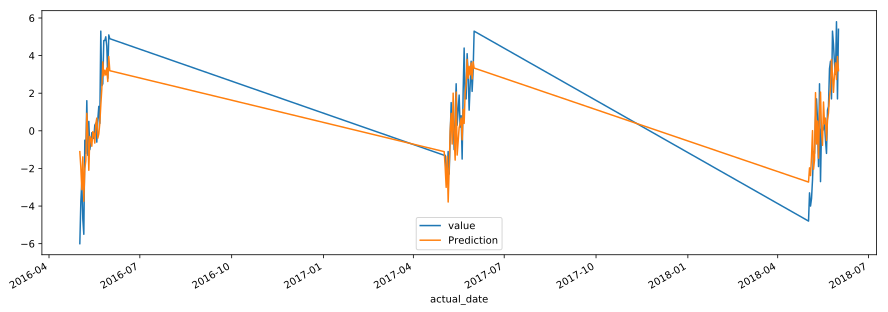

In [193]:
train = df1[df1.index.year <= extracted_year]
test = df1[df1.index.year > extracted_year]

y_train = train[['value']]
X_train = train.drop(['value'], axis=1)

y_test = test[['value']]
X_test = test.drop(['value'], axis=1)


reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

# # # This is a metric that simply sums up how many times each feature is split on.
# # _ = xgb.plot_importance(reg, height=0.9)

y_test['Prediction'] = reg.predict(X_test)
# pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

_ = y_test.plot(figsize=(15, 5))


In [194]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(y_true=y_test['value'],
                   y_pred=y_test['Prediction'])

2.671607009068485

In [195]:
mean_absolute_error(y_true=y_test['value'],
                   y_pred=y_test['Prediction'])

1.2618544482415721

In [197]:
y_test['error'] = y_test['value'] - y_test['Prediction']
y_test['abs_error'] = y_test['error'].apply(np.abs)

# # Over forecasted days
y_test.sort_values('error', ascending=True).head(10)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,value,Prediction,error,abs_error
actual_date,,,,
2016-05-01 21:00:00,-6.0,-1.1070322990,-4.8929677010,4.8929677010
2018-05-13 21:00:00,-2.7,2.0584554672,-4.7584554672,4.7584554672
2016-05-04 21:00:00,-4.7,-1.3859584332,-3.3140415668,3.3140415668
2018-05-05 21:00:00,-2.6,0.0094800889,-2.6094800889,2.6094800889
2017-05-26 21:00:00,1.1,3.4291043282,-2.3291043282,2.3291043282
2018-05-30 21:00:00,1.7,3.9502305984,-2.2502305984,2.2502305984
2018-05-04 21:00:00,-3.6,-1.3859584332,-2.2140415668,2.2140415668
2018-05-24 21:00:00,1.7,3.7977867126,-2.0977867126,2.0977867126
2018-05-01 21:00:00,-4.8,-2.7257907391,-2.0742092609,2.0742092609
